In [8]:
import random
import numpy as np
import matplotlib.pyplot as plt
import imageio

from libs.util import readImg, psnr
from libs.CFA import rgb2cfa, demosaicked

# Init

In [9]:
def generate_ac(H, W, seed, t):
    random.seed(seed)
    ac = np.zeros((H, W), dtype=np.uint8)
    for i in range(ac.shape[0]):
        for j in range(ac.shape[1]):
            ac[i, j] = random.randint(0, 2**t-1)
    return ac

In [10]:
def authentication_code_byPixel(pixel, t):
    sum = pixel.sum()
    pv = sum % 2**t
    return pv

def authentication_code(image, t):
    return np.array(image).sum(axis=2) % (2**t)

In [11]:
### Using random(package) to permutation
def permuted_1(perm, height, width, seed):
    _perm = perm.ravel()
    random.seed(seed)
    random.shuffle(_perm)
    return perm.reshape(height, width)

### Using np.random to permutation
def permuted_2(perm, height, width, seed):
    _perm = perm.ravel()
    np.random.seed(seed)
    permuted = np.random.permutation(_perm)
    return permuted.reshape(height, width)

### The original method to permutation used the np.random
def permuted_3(perm, height, width, seed):
    np.random.seed(seed)
    _perm = np.array(perm).ravel().reshape((1,height*width))
    permutation = list(np.random.permutation(height*width))
    return _perm[:, permutation].reshape(height, width)

def rePermuted_3(perm, height, width, seed):
    np.random.seed(seed)
    _perm = np.array(perm).ravel().reshape((1,height*width))
    permutation = list(np.random.permutation(height*width))
    rePermutation = sorted(range(len(permutation)), key=lambda k: permutation[k])
    return _perm[:, rePermutation].reshape(height, width)

In [12]:
### Get the low-order bits of the array
def getLowOrder(X, bits):
    return np.array(X) & ((1 << bits) - 1)

### Set the low-order bits of the array
def setLowOrder(X, bits, value):
    return (np.array(X) & ~((1 << bits) - 1)) | value

In [13]:
### Permuted the low-order bits of the array
def permutedLowOrder(arr, height, width, permutation_key, ld):
    LowOrderBits_Components = getLowOrder(arr, ld)
    permuted_LowOrder2Bits_Components = permuted_2(
        LowOrderBits_Components, 
        height, 
        width, 
        permutation_key
    )
    return setLowOrder(arr, ld, permuted_LowOrder2Bits_Components)

# Start to Embedding: Lenna_color Demo

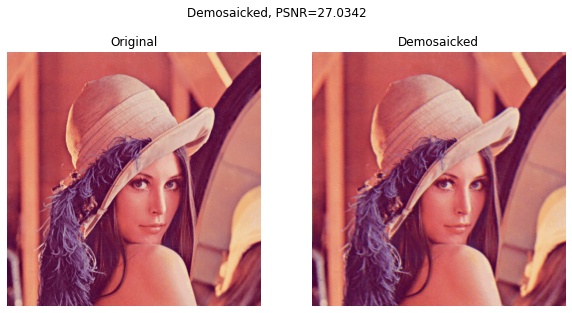

In [91]:
## User requirement
image = readImg("./Dataset/lena_color.gif")

cfa = rgb2cfa(image)
Demosaicked = demosaicked(cfa)
working_image = Demosaicked.astype(np.int16)
H, W = working_image.shape[:2]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Demosaicked, PSNR={:.4f}".format(psnr(image, working_image.astype('uint8'))))
axs[0].imshow(image)
axs[0].set_title("Original")
axs[0].axis('off')
axs[1].imshow(Demosaicked)
axs[1].set_title("Demosaicked")
axs[1].axis('off')
plt.show()

In [92]:
## User requierment
Sd = 7
t = 1
PK = 7

## 1. Authentication code calculate and embedding

In [93]:
acs = generate_ac(H, W, Sd, t)
pvs = authentication_code(Demosaicked, t)
dif = pvs - acs
dif[dif > 2**(t-1)] -= 2**t
dif[dif < -(2**(t-1))] += 2**t
dis_p1 = np.array(dif/2, np.int16)
dis_p2 = dif-dis_p1

working_image[:, :, 1] -= dis_p1
working_image[:, :, 2] -= dis_p2

In [94]:
### check the result is correct or not
embedded_pvs = authentication_code(working_image, t)
print("check embedding pvs is equal the acs or not: ", np.array_equal(acs, embedded_pvs))
embedded_image = np.copy(working_image)

check embedding pvs is equal the acs or not:  True


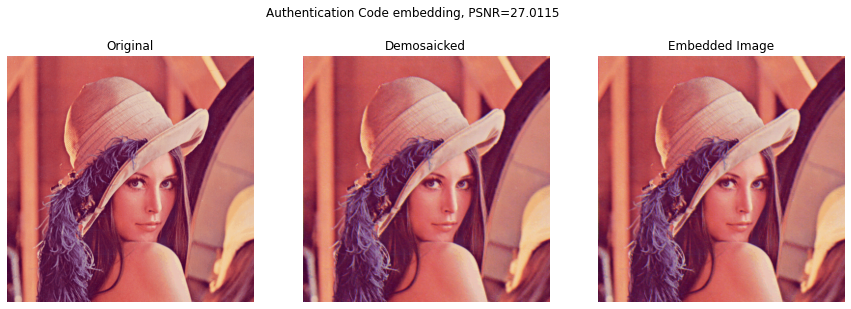

In [95]:
### show the result
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Authentication Code embedding, PSNR={:.4f}".format(psnr(image, embedded_image.astype('uint8'))))
axs[0].imshow(image)
axs[0].set_title("Original")
axs[0].axis('off')
axs[1].imshow(Demosaicked)
axs[1].set_title("Demosaicked")
axs[1].axis('off')
axs[2].imshow(embedded_image)
axs[2].set_title("Embedded Image")
axs[2].axis('off')
plt.show()


## Permuted the Low-order bits of the embedded image

In [96]:
working_image[:, :, 0] = permutedLowOrder(embedded_image[:, :, 0], height=H, width=W, permutation_key=PK, ld=t)
working_image[:, :, 1] = permutedLowOrder(embedded_image[:, :, 1], height=H, width=W, permutation_key=PK, ld=t)
working_image[:, :, 2] = permutedLowOrder(embedded_image[:, :, 2], height=H, width=W, permutation_key=PK, ld=t)
permuted_embedding_image = working_image.astype(np.uint8)

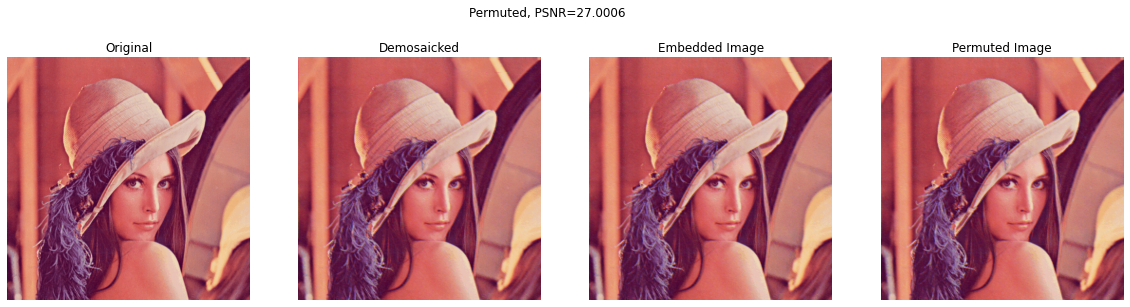

In [97]:
### show the result
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle("Permuted, PSNR={:.4f}".format(psnr(image, permuted_embedding_image)))
axs[0].imshow(image)
axs[0].set_title("Original")
axs[0].axis('off')
axs[1].imshow(Demosaicked)
axs[1].set_title("Demosaicked")
axs[1].axis('off')
axs[2].imshow(embedded_image)
axs[2].set_title("Embedded Image")
axs[2].axis('off')
axs[3].imshow(permuted_embedding_image)
axs[3].set_title("Permuted Image")
axs[3].axis('off')
plt.show()


In [98]:
imageio.imwrite(r"./img/lena_ACembedded_t={}.png".format(t), permuted_embedding_image)